In [1]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [2]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self):
        list_of_predict = {}
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
                print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        for i in range(len(list_of_predict)):
            self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
# folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
    folder = '/home/lpodgorsek/data/cnn/dicty/_15/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [3]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_15/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		0.27666% 	8.91827% 	0.04888		0.04571		0.0		1.0	
(1024,256) 	95.4% 		0.48427% 	6.34275% 	0.82382		0.83108		0.0		0.98575	
(1024,1024) 	3.04% 		1.85381% 	2.24378% 	0.02452		0.00294		0.0		0.91846	


In [4]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 1.00000 1.00000 0.00000 	(213910, 0.9037879560274013) 0.91352 0.90379 0.00973 	(688427, 0.938751472320377) 0.01916 0.93875 0.91959 	
(32635, 1.0) 1.00000 1.00000 0.00000 	(212974, 0.8941978001127759) 0.88892 0.89420 0.00528 	(4240, 0.9623085983510011) 0.23140 0.96231 0.73091 	
(2436, 1.0) 0.97229 1.00000 0.02771 	(44828, 0.8401417658060423) 0.86754 0.84014 0.02740 	(694929, 0.9799764428739693) 0.01287 0.97998 0.96711 	
(55808, 1.0) 0.99473 1.00000 0.00527 	(232148, 0.8783613613364569) 0.88501 0.87836 0.00665 	(600540, 0.5747938751472321) 0.01712 0.57479 0.55767 	
(44159, 1.0) 0.99159 1.00000 0.00841 	(106790, 0.8420843224691953) 0.87257 0.84208 0.03048 	(226406, 0.8680800942285042) 0.05421 0.86808 0.81387 	
(25344, 1.0) 1.00000 1.00000 0.00000 	(155900, 0.8219974944514251) 0.83907 0.82200 0.01707 	(122896, 0.99528857

(2438, 1.0) 0.84688 1.00000 0.15312 	(210231, 0.8654352000718556) 0.88056 0.86544 0.01513 	(247088, 0.9988221436984688) 0.01495 0.99882 0.98388 	
(23421, 1.0) 1.00000 1.00000 0.00000 	(102663, 0.8231137999290139) 0.87032 0.82311 0.04721 	(5113, 0.9081272084805654) 0.00031 0.90813 0.90781 	
(66812, 1.0) 0.97205 1.00000 0.02795 	(176870, 0.8457460818770137) 0.87891 0.84575 0.03316 	(474343, 0.9599528857479388) 0.04475 0.95995 0.91520 	
(68070, 1.0) 0.99594 1.00000 0.00406 	(13579, 0.7717501726755115) 0.46350 0.77175 0.30825 	(190691, 0.7856301531213193) 0.12391 0.78563 0.66172 	
(672, 1.0) 0.09913 1.00000 0.90087 	(203463, 0.8486464072366304) 0.87605 0.84865 0.02741 	(397756, 0.8928150765606597) 0.04045 0.89282 0.85237 	
(11903, 1.0) 0.99994 1.00000 0.00006 	(184233, 0.8349205207692031) 0.85533 0.83492 0.02041 	(1158, 0.009422850412249812) 0.15052 0.00942 0.14110 	
(80386, 1.0) 1.00000 1.00000 0.00000 	(81549, 0.9581239256984455) 0.89934 0.95812 0.05878 	(340263, 0.9988221436984688) 0.02

(102658, 1.0) 1.00000 1.00000 0.00000 	(147145, 0.8745215376148504) 0.87851 0.87452 0.00399 	(47292, 0.5594817432273262) 0.08152 0.55948 0.47796 	
(21504, 1.0) 1.00000 1.00000 0.00000 	(232269, 0.8728100116271399) 0.88303 0.87281 0.01022 	(235965, 0.7526501766784454) 0.07955 0.75265 0.67310 	
(49450, 1.0) 1.00000 1.00000 0.00000 	(218991, 0.916313607524709) 0.91874 0.91631 0.00242 	(266590, 0.8138987043580682) 0.06371 0.81390 0.75019 	
(12054, 1.0) 1.00000 1.00000 0.00000 	(212913, 0.9018670083500205) 0.90644 0.90187 0.00457 	(20497, 0.9305064782096585) 0.33070 0.93051 0.59981 	
(7428, 1.0) 0.99659 1.00000 0.00341 	(66448, 0.9062740326914251) 0.87173 0.90627 0.03454 	(104478, 0.4723203769140165) 0.17443 0.47232 0.29789 	
(59019, 1.0) 0.99771 1.00000 0.00229 	(169910, 0.8403865441871065) 0.88373 0.84039 0.04335 	(305504, 0.8857479387514724) 0.02702 0.88575 0.85872 	
(21886, 1.0) 1.00000 1.00000 0.00000 	(260457, 0.7862566444685708) 0.83064 0.78626 0.04438 	(471051, 0.9422850412249706) 0

(26752, 1.0) 1.00000 1.00000 0.00000 	(186891, 0.8033480663905581) 0.84870 0.80335 0.04535 	(190911, 0.480565371024735) 0.02989 0.48057 0.45068 	
(4237, 1.0) 0.10819 1.00000 0.89181 	(179828, 0.8500878475695915) 0.88171 0.85009 0.03162 	(125968, 0.9952885747938752) 0.27008 0.99529 0.72521 	
(18446, 1.0) 0.99971 1.00000 0.00029 	(210532, 0.8946273489263579) 0.88319 0.89463 0.01144 	(470199, 0.8409893992932863) 0.01592 0.84099 0.82507 	
(25215, 1.0) 1.00000 1.00000 0.00000 	(258372, 0.818371230272342) 0.84009 0.81837 0.02171 	(153781, 0.6195524146054182) 0.08227 0.61955 0.53728 	
(30380, 1.0) 1.00000 1.00000 0.00000 	(148287, 0.9223860427843692) 0.92303 0.92239 0.00064 	(146602, 0.9305064782096585) 0.49566 0.93051 0.43485 	
(34962, 1.0) 0.99855 1.00000 0.00145 	(159120, 0.8879360563357201) 0.88586 0.88794 0.00207 	(121940, 0.7997644287396938) 0.29988 0.79976 0.49988 	
(13180, 1.0) 0.98488 1.00000 0.01512 	(198907, 0.8310276470899663) 0.88434 0.83103 0.05332 	(657009, 0.9988221436984688) 

(59008, 1.0) 0.99863 1.00000 0.00137 	(145688, 0.8840907926988386) 0.86382 0.88409 0.02027 	(30880, 0.9988221436984688) 0.11124 0.99882 0.88758 	
(22315, 1.0) 0.99933 1.00000 0.00067 	(75870, 0.893131239258136) 0.87404 0.89313 0.01909 	(828942, 0.3074204946996466) 0.00931 0.30742 0.29811 	
(111104, 1.0) 1.00000 1.00000 0.00000 	(69828, 0.8517223587035576) 0.90874 0.85172 0.05702 	(148527, 0.5159010600706715) 0.17031 0.51590 0.34559 	
(10757, 1.0) 1.00000 1.00000 0.00000 	(170585, 0.8485697421085276) 0.88180 0.84857 0.03323 	(9486, 0.9104829210836279) 0.09034 0.91048 0.82014 	
(60419, 1.0) 0.99798 1.00000 0.00202 	(252754, 0.8910089570519085) 0.89407 0.89101 0.00306 	(2410, 0.5017667844522969) 0.12554 0.50177 0.37622 	
(108160, 1.0) 1.00000 1.00000 0.00000 	(484, 0.7804441747798809) 0.45566 0.78044 0.32478 	(119845, 0.7078916372202592) 0.17031 0.70789 0.53758 	
(10365, 1.0) 0.99240 1.00000 0.00760 	(79323, 0.899918302176771) 0.88523 0.89992 0.01469 	(345153, 0.8798586572438163) 0.17404 

(129921, 1.0) 1.00000 1.00000 0.00000 	(42822, 0.7588843823223201) 0.87262 0.75888 0.11373 	(84196, 0.92226148409894) 0.08630 0.92226 0.83596 	
(12671, 1.0) 1.00000 1.00000 0.00000 	(261373, 0.7917948910537543) 0.84611 0.79179 0.05432 	(70842, 0.9458186101295644) 0.12426 0.94582 0.82155 	
(70918, 1.0) 0.96292 1.00000 0.03708 	(201581, 0.8300839268039246) 0.85451 0.83008 0.02443 	(4241, 0.9623085983510011) 0.23015 0.96231 0.73216 	
(20493, 1.0) 0.85404 1.00000 0.14596 	(185007, 0.8389086283169533) 0.85700 0.83891 0.01809 	(383200, 0.8939929328621907) 0.02093 0.89399 0.87306 	
(4615, 1.0) 0.96308 1.00000 0.03692 	(105089, 0.8015273975526116) 0.88675 0.80153 0.08522 	(344194, 0.9740871613663132) 0.05492 0.97409 0.91917 	
(78208, 1.0) 1.00000 1.00000 0.00000 	(181594, 0.8313319908016144) 0.88014 0.83133 0.04881 	(11483, 0.8833922261484101) 0.12696 0.88339 0.75643 	
(11008, 1.0) 1.00000 1.00000 0.00000 	(226981, 0.8566625346847325) 0.88205 0.85666 0.02539 	(24576, 0.36277974087161374) 0.337

(20255, 1.0) 0.99938 1.00000 0.00062 	(250233, 0.9003757619497575) 0.89093 0.90038 0.00945 	(205973, 0.004711425206124825) 0.04697 0.00471 0.04226 	
(10109, 1.0) 1.00000 1.00000 0.00000 	(15573, 0.7999235713645879) 0.84632 0.79992 0.04639 	(247410, 0.20023557126030625) 0.00639 0.20024 0.19385 	
(108416, 1.0) 1.00000 1.00000 0.00000 	(75173, 0.8174853669777551) 0.86750 0.81749 0.05002 	(369990, 0.9976442873969376) 0.06302 0.99764 0.93463 	
(24843, 1.0) 0.99505 1.00000 0.00495 	(90835, 0.8359099894725593) 0.87413 0.83591 0.03822 	(77854, 0.9988221436984688) 0.17443 0.99882 0.82440 	
(79235, 1.0) 1.00000 1.00000 0.00000 	(50039, 0.7863033520151788) 0.84307 0.78630 0.05677 	(146442, 0.7597173144876326) 0.26786 0.75972 0.49186 	
(20113, 1.0) 0.99965 1.00000 0.00035 	(105923, 0.8117617364765212) 0.88152 0.81176 0.06976 	(25613, 0.9328621908127209) 0.33214 0.93286 0.60072 	
(1788, 1.0) 0.48118 1.00000 0.51882 	(92278, 0.8541189502133024) 0.87597 0.85412 0.02185 	(190742, 0.9670200235571261) 0

(66576, 1.0) 0.99577 1.00000 0.00423 	(31767, 0.8012019621432349) 0.83534 0.80120 0.03413 	(507024, 0.9493521790341579) 0.09291 0.94935 0.85644 	
(39037, 1.0) 0.99614 1.00000 0.00386 	(59716, 0.91944520897529) 0.89794 0.91945 0.02150 	(158779, 0.877502944640754) 0.17031 0.87750 0.70719 	
(77314, 1.0) 1.00000 1.00000 0.00000 	(243788, 0.881446159303269) 0.88599 0.88145 0.00455 	(173242, 0.8610129564193169) 0.06057 0.86101 0.80044 	
(123521, 1.0) 1.00000 1.00000 0.00000 	(73257, 0.8188768717054294) 0.85211 0.81888 0.03323 	(506000, 0.9493521790341579) 0.09205 0.94935 0.85730 	
(76943, 1.0) 1.00000 1.00000 0.00000 	(260121, 0.8137379243947204) 0.84081 0.81374 0.02707 	(51316, 0.9988221436984688) 0.12735 0.99882 0.87147 	
(2192, 1.0) 0.29235 1.00000 0.70765 	(66481, 0.9058222626938063) 0.88378 0.90582 0.02204 	(709107, 0.9988221436984688) 0.01614 0.99882 0.98268 	
(56067, 1.0) 1.00000 1.00000 0.00000 	(202722, 0.8630601619630203) 0.88676 0.86306 0.02370 	(52608, 0.7561837455830389) 0.14031

(48897, 1.0) 0.99999 1.00000 0.00001 	(113790, 0.9733947675958406) 0.95474 0.97339 0.01866 	(868912, 0.5665488810365136) 0.00387 0.56655 0.56268 	
(113793, 1.0) 1.00000 1.00000 0.00000 	(49410, 0.7956718475747022) 0.83566 0.79567 0.03999 	(51766, 0.9988221436984688) 0.03078 0.99882 0.96805 	
(24342, 1.0) 1.00000 1.00000 0.00000 	(17420, 0.7563035891312273) 0.70287 0.75630 0.05343 	(289885, 0.7773851590106008) 0.05316 0.77739 0.72423 	
(26511, 1.0) 1.00000 1.00000 0.00000 	(53460, 0.83468955915907) 0.87509 0.83469 0.04040 	(220310, 0.850412249705536) 0.07460 0.85041 0.77582 	
(103042, 1.0) 1.00000 1.00000 0.00000 	(179325, 0.8734828094900088) 0.87289 0.87348 0.00059 	(17709, 0.9846878680800943) 0.09934 0.98469 0.88535 	
(3716, 1.0) 0.94200 1.00000 0.05800 	(157756, 0.8853293007137243) 0.85635 0.88533 0.02898 	(831604, 1.0) 0.00659 1.00000 0.99341 	
(23310, 1.0) 1.00000 1.00000 0.00000 	(65303, 0.7991134418659879) 0.83257 0.79911 0.03346 	(140403, 0.790341578327444) 0.06363 0.79034 0.726

(7805, 1.0) 1.00000 1.00000 0.00000 	(235823, 0.8878358098654316) 0.88488 0.88784 0.00295 	(19665, 0.795053003533569) 0.12660 0.79505 0.66845 	
(86656, 1.0) 1.00000 1.00000 0.00000 	(40342, 0.8407967854037682) 0.87294 0.84080 0.03214 	(30089, 0.9316843345111897) 0.06791 0.93168 0.86377 	
(40066, 1.0) 0.99878 1.00000 0.00122 	(239946, 0.8806124561907951) 0.88802 0.88061 0.00741 	(489827, 1.0) 0.01765 1.00000 0.98235 	
(34172, 1.0) 1.00000 1.00000 0.00000 	(209744, 0.8737684384705816) 0.86157 0.87377 0.01220 	(226435, 0.92226148409894) 0.08262 0.92226 0.83964 	
(9472, 1.0) 1.00000 1.00000 0.00000 	(104732, 0.8014039991379013) 0.87071 0.80140 0.06931 	(783395, 0.8928150765606597) 0.02255 0.89282 0.87027 	
(75908, 1.0) 1.00000 1.00000 0.00000 	(75644, 0.8643310671561585) 0.88042 0.86433 0.01608 	(33941, 0.35924617196702) 0.16517 0.35925 0.19408 	
(899, 1.0) 0.50242 1.00000 0.49758 	(39198, 0.8438774699391952) 0.84777 0.84388 0.00389 	(708158, 0.9269729093050648) 0.01411 0.92697 0.91286 	
(

(7179, 1.0) 1.00000 1.00000 0.00000 	(115318, 0.9613607611985239) 0.94904 0.96136 0.01232 	(19151, 0.9764428739693758) 0.01746 0.97644 0.95898 	
(50232, 1.0) 0.99996 1.00000 0.00004 	(256205, 0.8824501118182928) 0.89208 0.88245 0.00963 	(228535, 0.92226148409894) 0.08379 0.92226 0.83847 	
(41854, 1.0) 1.00000 1.00000 0.00000 	(117693, 0.8768031935291722) 0.87930 0.87680 0.00250 	(110592, 0.46760895170789174) 0.31090 0.46761 0.15671 	
(105472, 1.0) 1.00000 1.00000 0.00000 	(212900, 0.9023480951912478) 0.90190 0.90235 0.00045 	(447844, 0.96113074204947) 0.03416 0.96113 0.92697 	
(39040, 1.0) 1.00000 1.00000 0.00000 	(145485, 0.8335137407392648) 0.88365 0.83351 0.05014 	(12479, 0.7526501766784454) 0.19700 0.75265 0.55565 	
(8073, 1.0) 0.99943 1.00000 0.00057 	(222550, 0.8526589924594489) 0.88825 0.85266 0.03559 	(59429, 0.7844522968197879) 0.17031 0.78445 0.61414 	
(96642, 1.0) 0.87139 1.00000 0.12861 	(200530, 0.8433384104301047) 0.86624 0.84334 0.02290 	(456949, 0.9587750294464076) 0.02

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


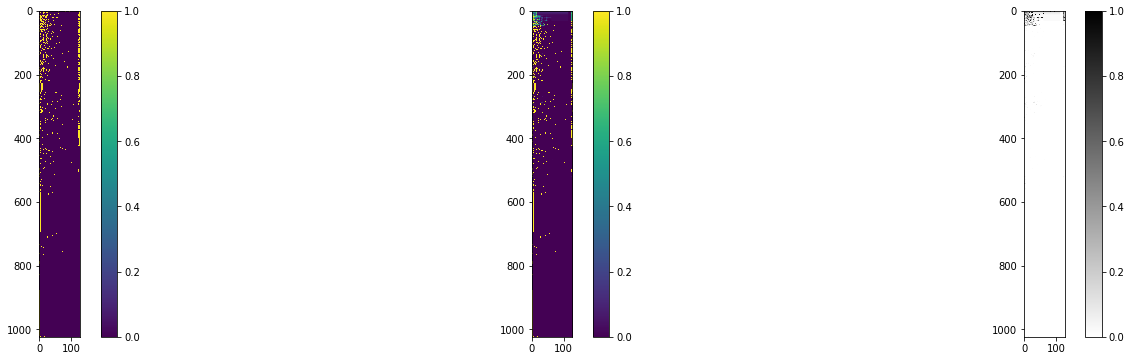

1.1956638e-07
0.98575366


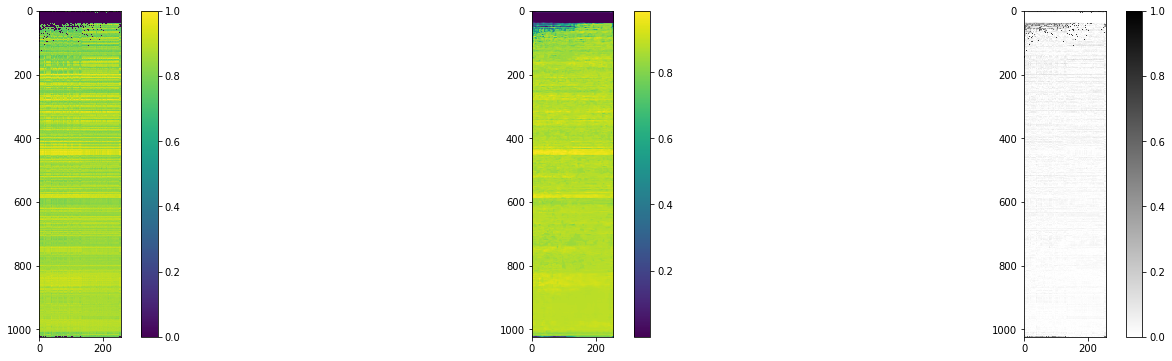

3.719328e-12
0.9184636


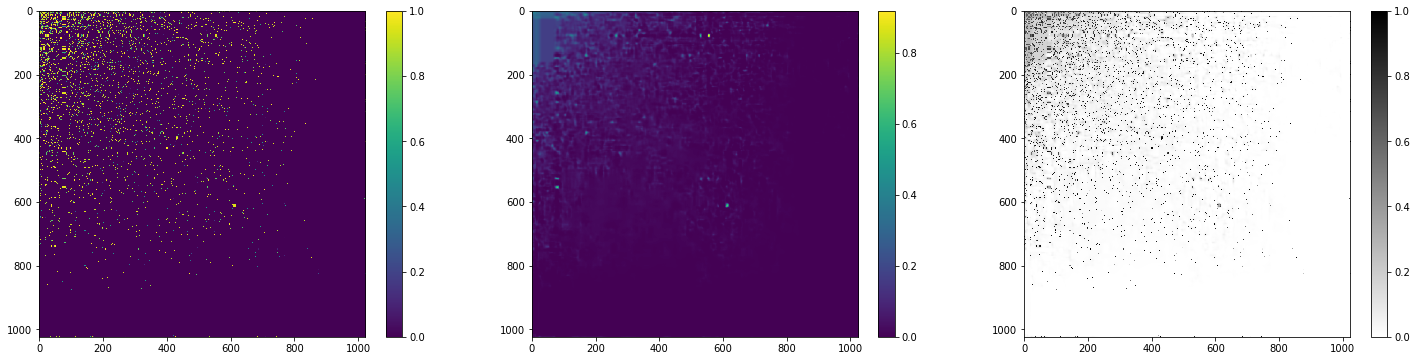

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/_15/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

    ax = axes[2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


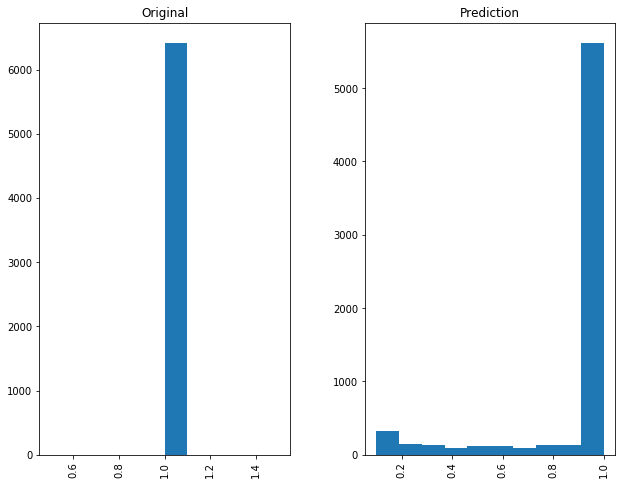

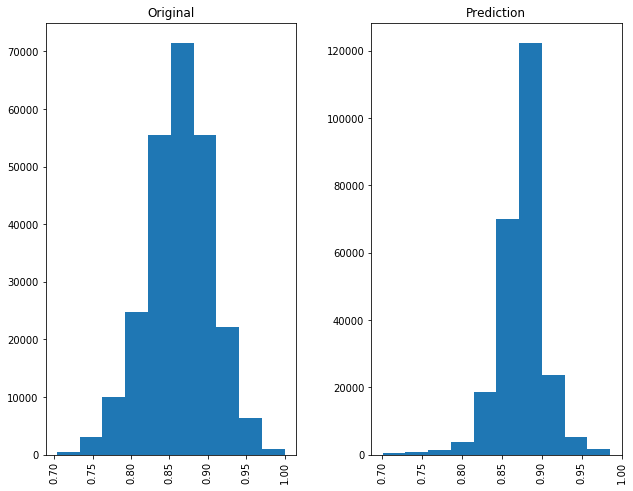

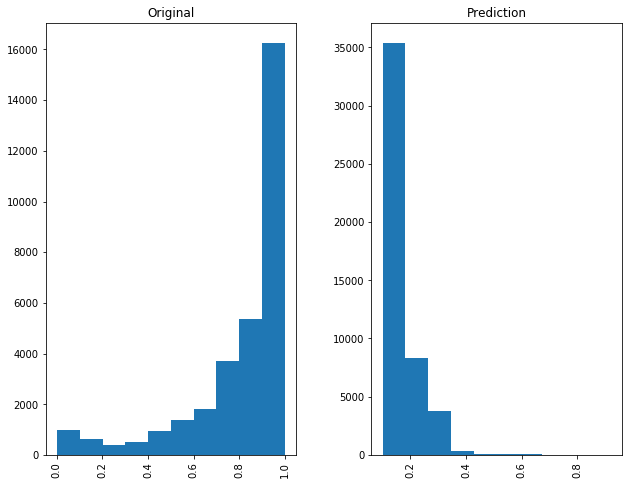

In [7]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'histogram_distribution_' + str(i))
    

/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


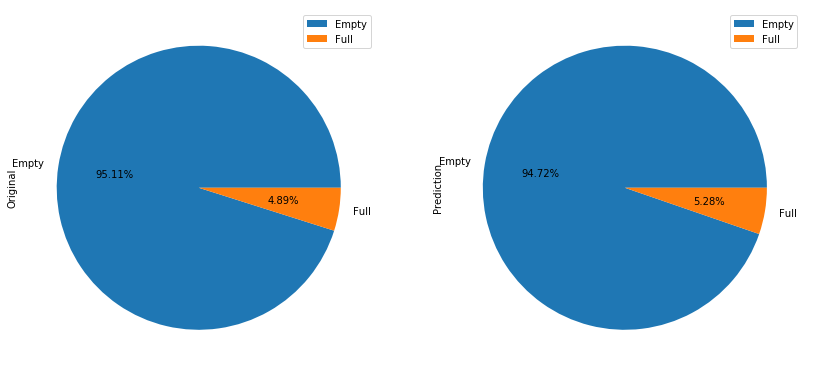

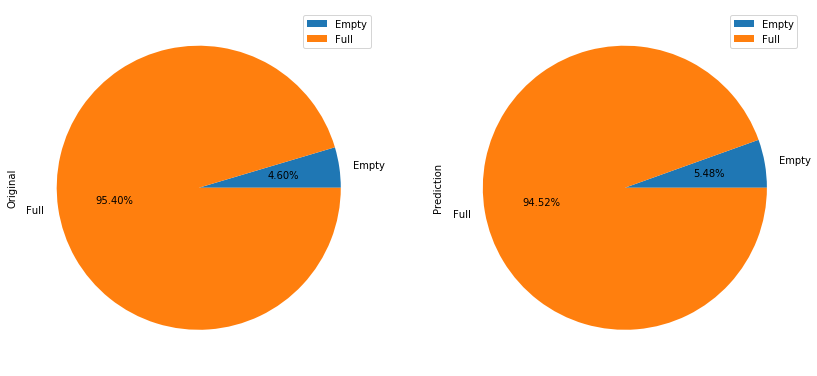

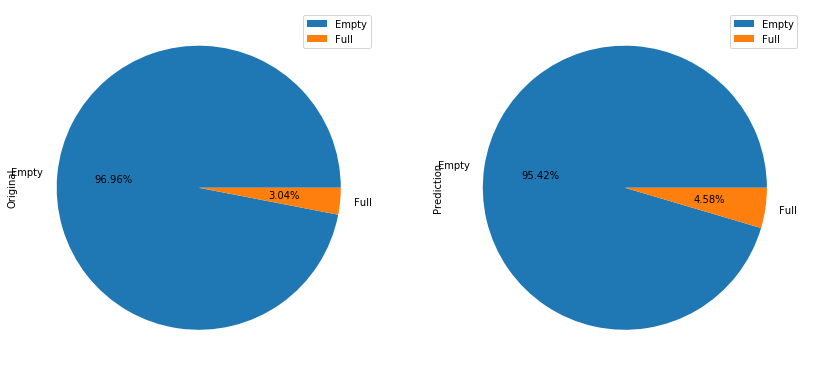

In [8]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    length = len(org_data)
    d = {}
    d['Original'] = []
    d['Original'].append(len(org_data[org_data == 0]) / length)
    d['Original'].append(len(org_data[org_data > 0]) / length)

    if i == 1:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.7]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.7]) / length)
    else:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.1]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.1]) / length)

    fig, ax = plt.subplots(figsize=(14,8))
    df = pd.DataFrame(d, index=['Empty', 'Full'])
    df.plot.pie(subplots=True, figsize=(14, 8), autopct='%.2f%%', ax=ax)
    fig.savefig(path + 'pie_density_' + str(i))

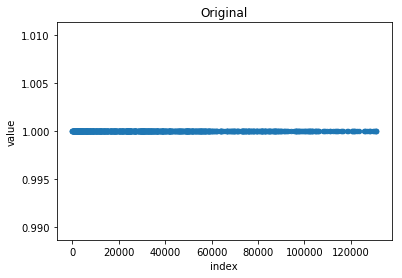

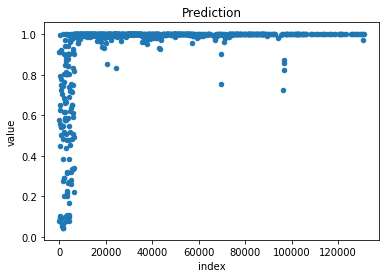

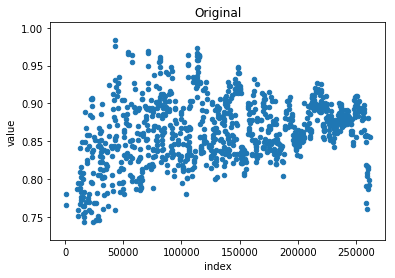

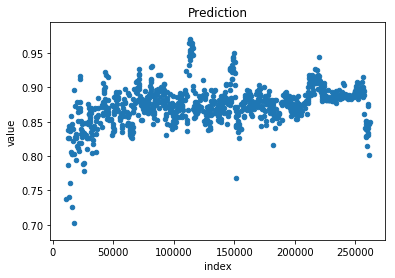

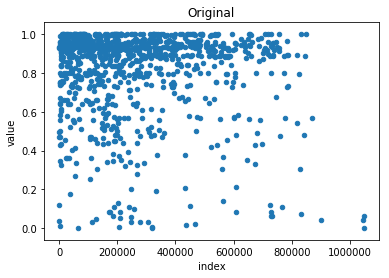

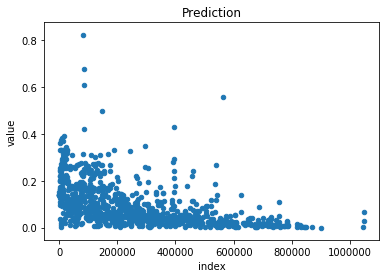

In [9]:
for i in range(len(model.org_data)):
    # df.plot.scatter(x='a', y='b');
    # print(np.random.rand(50, 4))
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    # print(data)
    new_org_data = []
    new_predict_data = []
    for j in range(len(org_data)):
        if i == 1:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            if predict_data[j][1] > 0.7:
                new_predict_data.append([predict_data[j][0], predict_data[j][1]])
        else:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            new_predict_data.append([predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(new_org_data, columns=['index', 'value'])
    df.plot.scatter(x='index', y='value', title='Original');

    df = pd.DataFrame(new_predict_data, columns=['index', 'value'])
    df.plot.scatter(x='index', y='value', title='Prediction');

    new_predict_data

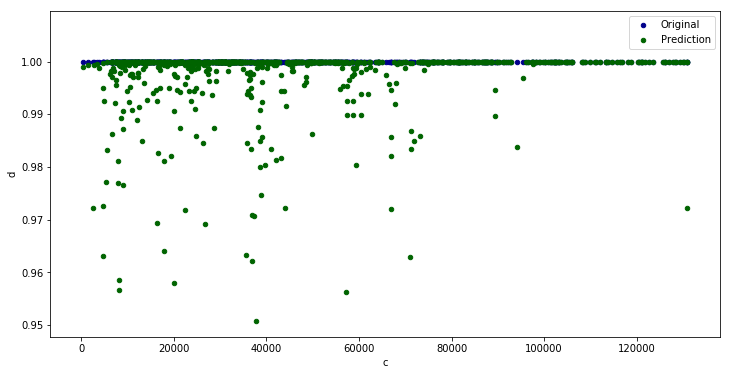

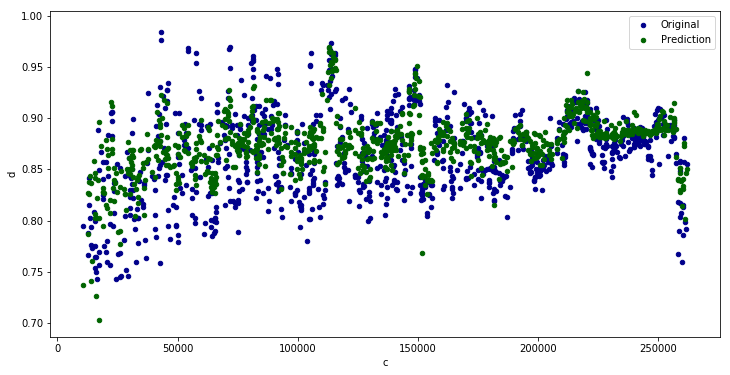

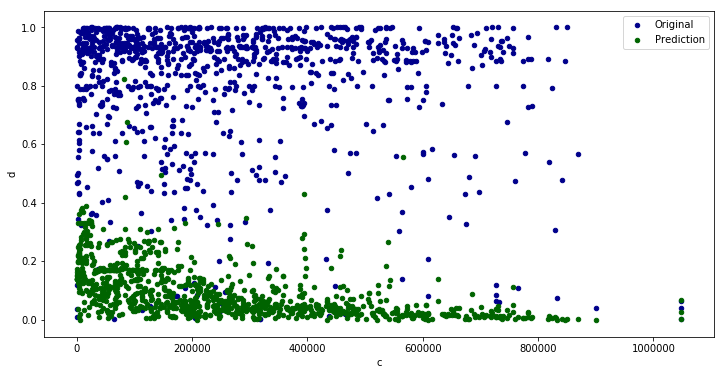

In [10]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original', ax=ax);
    ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));
    fig.savefig(path + 'scatter_org_vs_prediction_' + str(i) + '.png')

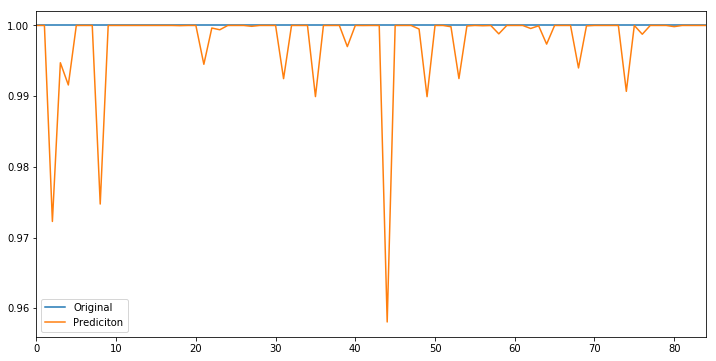

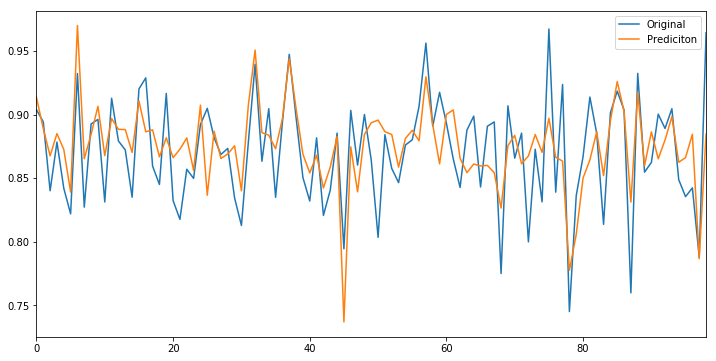

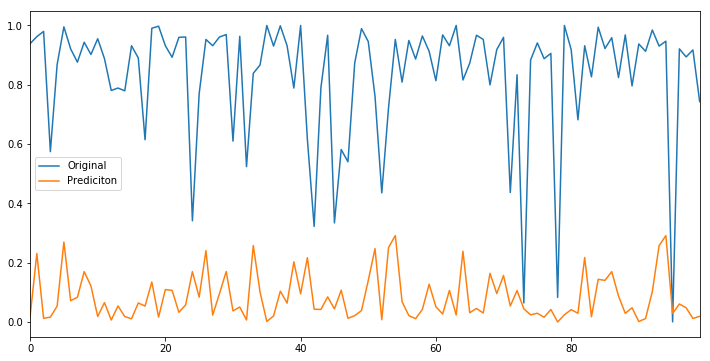

In [11]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data[:100])):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][1], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][1], predict_data[j][1]])
        else:
            data.append([org_data[j][1], predict_data[j][1]])

    fig, ax = plt.subplots(figsize=(12,6))
    df = pd.DataFrame(data, columns=['Original', 'Prediciton'])
    df.plot(subplots=False, figsize=(12,6), ax=ax)
    fig.savefig(path + 'graph_org_vs_prediction_' + str(i))